# PCA + MLP approach - stock 9061

For LOB we perform $GDF(k, r, s)$ filtering on concated **bid and ask lists** with K=50 and $r \in {0.01, 0.1, 1.0}$, $ s \in {0.1, 1.0} $. We obtain 50 gdf features with values between 0 and 1.

We also introduce:
* `queue_imbalance`
* `prev_queue_imbalance` (for sample from tick $t$ `prev_queue_imbalance` is `queue_imbalance` value from previous tick $t-1$). 

In total our feature set is:
* `queue_imbalance`
* `prev_queue_imbalance`
* 50 features: $gdf_i$ for $i \in (0, 50) $


Next we perform dimensionality reduction using PCA(n_components=10) on these features. We do NOT perform mean normalization since queue imbalance and prev queue imbalance are between (-1, 1) and all gdf features are between (0, 1). We want queue imbalance to have bigger inpact on the result of the reduction.

Next we input 10 features obtained after PCA to MLP algorithm.

In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

import warnings
import numpy as np
from collections import OrderedDict

import os

from lob_data_utils import lob, db_result, gdf_pca, model
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
data_length = 15000
stock = '9061'
gdf_filename_pattern = 'gdf_{}_' + 'len{}'.format(data_length) + '_r{}_s{}_K50'
gdf_parameters = [(1.0, 1.0), (0.1, 0.1), (0.1, 1.0), (1.0, 0.1), (0.01, 0.1)] # pairs of params (r, s)

In [3]:
gdf_dfs = []
for r, s in gdf_parameters:
    gdf_dfs.append(gdf_pca.SvmGdfResults(
        stock,  r=r, s=s, data_length=data_length, 
        gdf_filename_pattern=gdf_filename_pattern))

In [4]:
def get_kernel_from_method(method):
    return method.split('_')[1]

class CFR():
    def __init__(self, clf, feature_name, is_svm=True):
        self.clf = clf
        self.feature_name = feature_name
        self.is_svm = is_svm

    def get_result(self, gdf_df, should_validate=False, method=None):
        if self.is_svm:
            return gdf_df.train_svm(C=self.clf.C, gamma=self.clf.gamma, coef0=self.clf.coef0, 
                                    kernel=self.clf.kernel, 
                                    feature_name=self.feature_name, should_validate=should_validate)
        else:
            res = gdf_df.train_clf(self.clf, self.feature_name, should_validate=should_validate)
            if method:
                res['kernel'] = method
            return res

## PCA Visualization

I'm not sure how to visualize PCA.

In [5]:
train_x = gdf_dfs[3].df[gdf_dfs[3].feature_columns_dict['pca_gdf_que_prev10']]
n_components = 10
pca_columns = [f'pca_{i}' for i in range(0, n_components)]


pca = PCA(n_components=n_components)
pca.fit(train_x)
train_x = pca.transform(train_x)
df_pca = pd.DataFrame(data=train_x, columns=pca_columns)
df_pca.index = gdf_dfs[3].df.index
df_pca = pd.concat([df_pca, gdf_dfs[3].df], axis=1)

In [6]:
df_pca[pca_columns + ['gdf_20', 'gdf_30', 'queue_imbalance']].head()

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,gdf_20,gdf_30,queue_imbalance
datetime,,,,,,,,,,,,,
2013-09-13 10:37:00,0.049406,0.592455,0.034111,0.005467,0.018500,0.019298,0.010250,-0.000471,-0.018495,-0.006900,0.036786,0.057426,-0.438189
2013-09-13 10:39:00,0.278515,-0.362025,0.037417,-0.013449,-0.003641,-0.002153,0.002891,0.012107,-0.010638,0.009309,0.045412,0.050620,0.073354
2013-09-13 10:40:00,-0.309452,-0.226335,0.033761,-0.001028,0.019771,0.021995,0.010848,0.012750,-0.017672,0.001252,0.043225,0.060088,0.394028
2013-09-13 10:41:00,-0.807490,-0.270313,0.046370,0.022142,0.041487,0.004859,0.003615,-0.005055,-0.014021,0.027935,0.039810,0.061297,0.777939
2013-09-13 10:42:00,-0.414910,0.664032,0.034404,0.002332,0.012025,0.009572,0.001493,0.031313,-0.000336,-0.005042,0.041549,0.058348,-0.160485


Text(0,0.5,'PCA 1')

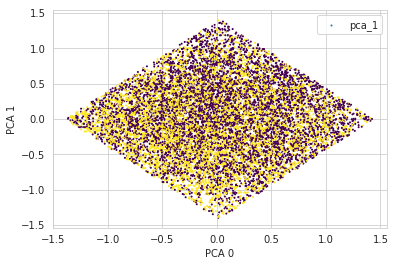

In [7]:
plt.scatter(df_pca.loc[:, 'pca_0'], df_pca.loc[:, 'pca_1'], 
            c=df_pca['mid_price_indicator'], s=1,
           cmap='viridis')
plt.legend()
plt.xlabel('PCA 0')
plt.ylabel('PCA 1')

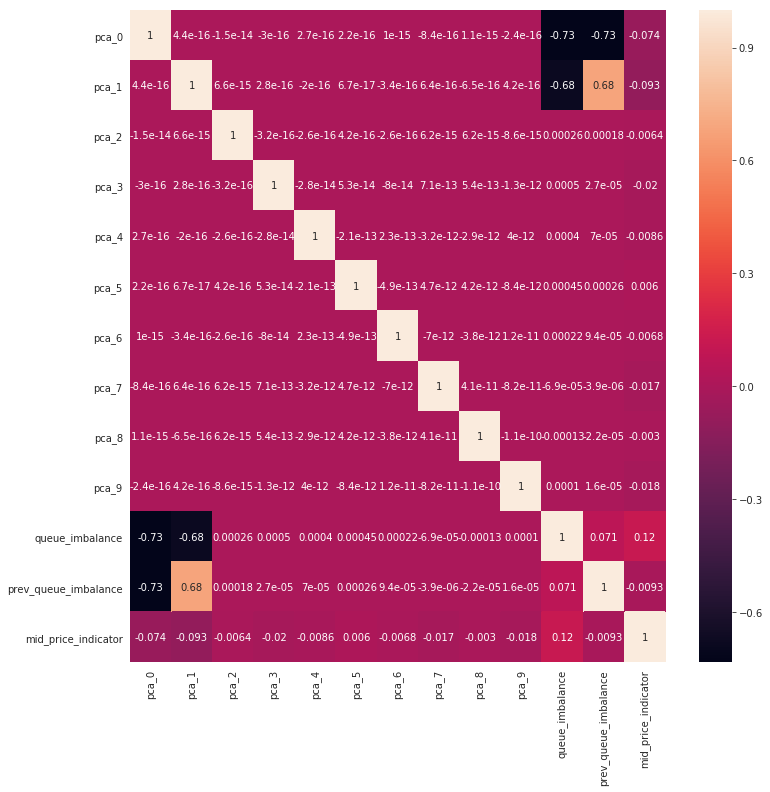

In [8]:
plt.figure(figsize=(12, 12))
sns.heatmap(df_pca[pca_columns + ['queue_imbalance', 'prev_queue_imbalance', 'mid_price_indicator']].corr(), 
            annot=True)

Text(0.5,1,'GDF 20-30 over time')

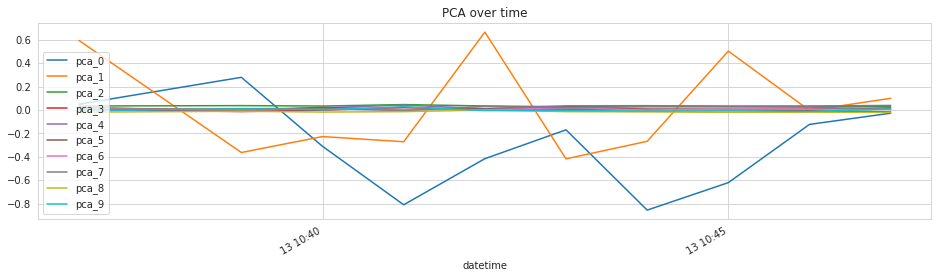

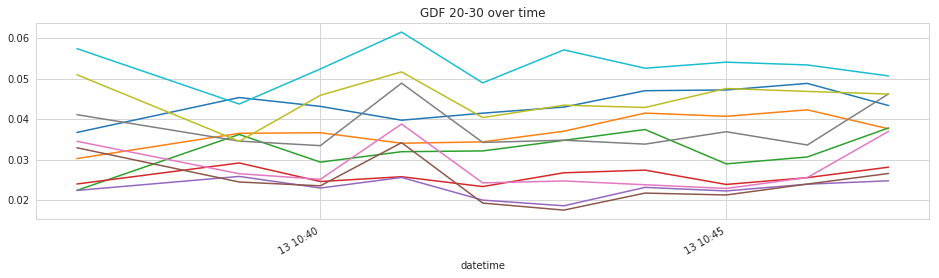

In [9]:
df_pca[pca_columns].iloc[0:10].plot(figsize=(16, 4))
plt.title('PCA over time')
df_pca.iloc[0:10][[f'gdf_{i}' for i in range(20, 30)]].plot(figsize=(16, 4), legend=None)
plt.title('GDF 20-30 over time')

Explained variance: [3.00087033e-01 2.60305614e-01 3.50310190e-03 1.32605641e-03
 9.03897756e-04 7.98029167e-04 6.69492100e-04 4.95541596e-04
 3.91729422e-04 2.69675624e-04]
Explained variance ratio:  [5.26614697e-01 4.56803350e-01 6.14749970e-03 2.32706087e-03
 1.58622596e-03 1.40044001e-03 1.17487376e-03 8.69612674e-04
 6.87435472e-04 4.73246529e-04]


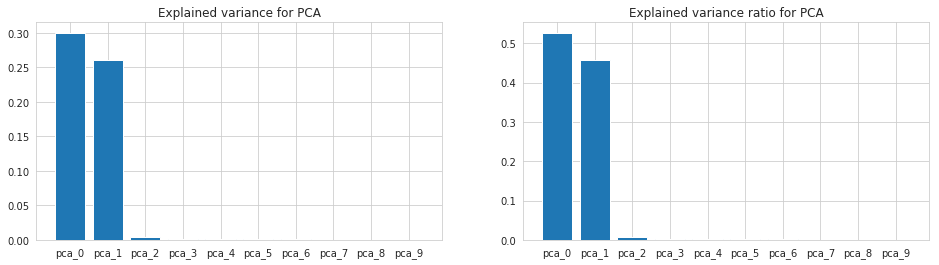

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.bar(pca_columns, pca.explained_variance_)
ax1.set_title('Explained variance for PCA')
ax2.bar(pca_columns, pca.explained_variance_ratio_)
ax2.set_title('Explained variance ratio for PCA')
print('Explained variance:', pca.explained_variance_)
print('Explained variance ratio: ', pca.explained_variance_ratio_)

## MLP

We tried different sets of features as inputs to MLP:

* pca_gdf_que_prev10 - we obtain them by reducting all GDF features and queue imbalance and prev queue imbalance using PCA to 10 dimensions
* pca_gdf_que10 - all GDF and queue_imbalance reducted to 10 features using PCA
* pca_gdf10 - all GDF features reducted to 10 features using PCA

All GDF features are a set of $gdf_i$ for $i \in (0, 50)$

Output: mid price indicator

### Hyperparameters

* r - parameter for GDF
* s - parameter for GDF
* alpha - L2 penalty parameter from set $ [1.0, 0.1, 0.01, 0.0001, 0.001]$
* hidden_layer_size - number of hidden layers from set ${(8, 8), (8, 16), (8), (16), (16, 16), (16, 8)}$
* activation function - tanh
* solver - adam

### Validation

We used 10-fold forward anchored cross validation:
![val](https://raw.githubusercontent.com/vevurka/mt-lob/master/pictures_for_mt/pic_base/forward_anchored_validation.png)

We measure MCC (Matthews Correlation Coefficient) and ROC area score. Choice of best classifier is done using MCC instead of ROC area score, since MCC is not prone to class imbalance issues (different amounts of positives and negatives in data set). Of course for most of the stocks we observed that classes are usually balanced. But also usually classifier with highest MCC score on validation set has also the highest ROC area score.

In [11]:
df_res = pd.read_csv(f'res_{stock}_mlp.csv')
columns = ['r','s', 'alpha', 'hidden_layer_size', 'features', 'matthews', 'roc_auc', 
           'test_matthews', 'test_roc_auc', 'train_matthews', 'train_roc_auc']
df_res = df_res[columns].sort_values(by='matthews', ascending=False)
df_res.head()

,r,s,alpha,hidden_layer_size,features,matthews,roc_auc,test_matthews,test_roc_auc,train_matthews,train_roc_auc
0,1.0,1.0,1.0000,16,pca_gdf_que_prev10,0.108440,0.552269,0.069272,0.534385,0.091777,0.545116
1,0.1,1.0,0.0010,"(8, 16)",pca_gdf_que_prev10,0.108321,0.551833,0.065849,0.531894,0.089825,0.543940
2,0.1,1.0,0.0001,"(8, 16)",pca_gdf_que_prev10,0.108321,0.551833,0.065849,0.531894,0.090011,0.544028
3,0.1,1.0,0.0100,"(8, 16)",pca_gdf_que_prev10,0.106870,0.551019,0.065155,0.531563,0.088911,0.543411
4,0.1,1.0,1.0000,16,pca_gdf_que_prev10,0.106578,0.551371,0.069942,0.534732,0.094799,0.546558


In the table above `matthews` is a MCC validation score, `roc_auc` is ROC area validation score. These are 5 best results - the best one is on the top, they are sorted by MCC. We recorded test scores for all classifiers, but they were not used for comparision.

Text(0.5,1,'Validation MCC score for 9061')

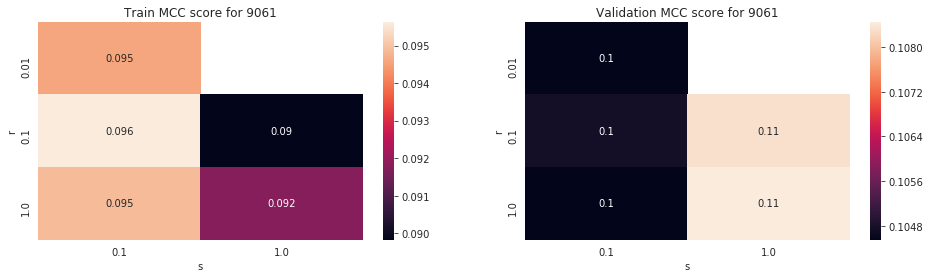

In [12]:
d = df_res[df_res['features'] == 'pca_gdf_que_prev10'][columns].groupby(
    ['r', 's']).head(1).sort_values(by=['matthews'], ascending=False)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 4))

sns.heatmap(data=d[[ 'r', 's', 'train_matthews']].pivot(
    index='r', columns='s', values=['train_matthews'])['train_matthews'], ax=ax0, annot=True)
ax0.set_title('Train MCC score for {}'.format(stock))
data = d[[ 'r', 's', 'matthews']].pivot(
    index='r', columns='s', values=['matthews'])['matthews']
sns.heatmap(data=data,  ax=ax1, annot=True)
ax1.set_title('Validation MCC score for {}'.format(stock))

Heatmaps with score comparision between different GDF parameters r and s.

In [13]:
log_columns = ['matthews', 'roc_auc', 'test_matthews', 'test_roc_auc', 'train_matthews', 'train_roc_auc']

df_res_log = pd.read_csv('res_overview_all_three_logistic_regression.csv')
df_res_log = df_res_log[df_res_log['stock'] == int(stock)]
df_res_log = df_res_log[log_columns].sort_values(by='matthews', ascending=False)
df_res_log

,matthews,roc_auc,test_matthews,test_roc_auc,train_matthews,train_roc_auc
1,0.098933,0.548301,0.062334,0.531108,0.091511,0.545188


This is the result obtained by using Logistic Regression with Queue Imbalance as a feature.

In [14]:
df_res_best = df_res.head(1)
for c in df_res_log.columns:
    df_res_best[f'log_{c}'] = df_res_log[c].values
df_res_best

,r,s,alpha,hidden_layer_size,features,matthews,roc_auc,test_matthews,test_roc_auc,train_matthews,train_roc_auc,log_matthews,log_roc_auc,log_test_matthews,log_test_roc_auc,log_train_matthews,log_train_roc_auc
0,1.0,1.0,1.0,16,pca_gdf_que_prev10,0.10844,0.552269,0.069272,0.534385,0.091777,0.545116,0.098933,0.548301,0.062334,0.531108,0.091511,0.545188


Data frame with best PCA+GDF+MLP and logistic regression scores (there have prefix log_) to make some plots with these results.

,matthews,log_matthews,test_matthews,log_test_matthews,train_matthews,log_train_matthews
0,0.10844,0.098933,0.069272,0.062334,0.091777,0.091511


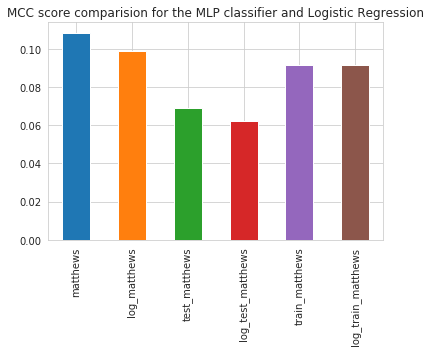

In [15]:
bar_columns = ['matthews', 'log_matthews', 'test_matthews', 
               'log_test_matthews', 'train_matthews', 'log_train_matthews']
df_res_best[bar_columns].unstack().plot(kind='bar')
x = plt.xticks(list(range(len(bar_columns))), bar_columns)

plt.title('MCC score comparision for the MLP classifier and Logistic Regression')
df_res_best[bar_columns]

,roc_auc,log_roc_auc,test_roc_auc,log_test_roc_auc,train_roc_auc,log_train_roc_auc
0,0.552269,0.548301,0.534385,0.531108,0.545116,0.545188


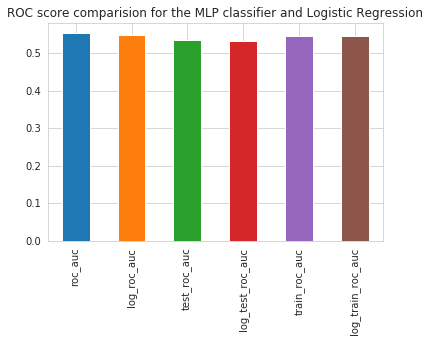

In [16]:
bar_columns = ['roc_auc', 'log_roc_auc', 'test_roc_auc', 
               'log_test_roc_auc', 'train_roc_auc', 'log_train_roc_auc']
df_res_best[bar_columns].unstack().plot(kind='bar')
x = plt.xticks(list(range(len(bar_columns))), bar_columns)
plt.title('ROC score comparision for the MLP classifier and Logistic Regression')
df_res_best[bar_columns]

## Conclusion

GDF+PCA+MLP performs better - for MCC score by 0.004 for ROC 0.003. The results on validation set and testing set differ, I think we might overfit a bit.